**Цель :**

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

   1. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
   2. Включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
   3. Используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

**Ход работы:**

1. Предобработать исходные данные о клиентах: удалить дубликаты, пропуски, привети данные к необходимому типу
2. Провести исследовательский анализ данных: изучить данные, их зависимости, распределения, выявить выбросы. Отбрать клиентов с покупательской активностью не менее трёх месяцев.
3. Объединить данные в одну таблицу. Добавить отдельный столбец для каждого периода активности.
4. Провести корреляционный анализ признаков.
5. Написать пайплайны: предобработать данные, обучить, выбрать лучшую модель и гиперпараметр.
6. Провести анализ важности признаков с помощью SHAP.
7. Провести сегментацию покупателей.
8. Подвести итоги.

## Загрузка данных

Импортируем необходимые для работы библиотеки

In [1]:
pip install phik

Could not fetch URL https://pypi.org/simple/phik/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/phik/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)'))) - skipping
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement phik (from versions: none)
ERROR: No matching distribution found for phik


In [2]:
!pip install -Uq scikit-learn

In [3]:
pip install shap

Could not fetch URL https://pypi.org/simple/shap/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/shap/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)'))) - skipping
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement shap (from versions: none)
ERROR: No matching distribution found for shap


In [4]:
pip install optuna-integration[sklearn]

Could not fetch URL https://pypi.org/simple/optuna-integration/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/optuna-integration/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)'))) - skipping
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement optuna-integration[sklearn] (from versions: none)
ERROR: No matching distribution found for optuna-integration[sklearn]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
import sklearn
import statistics
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# дополнительные классы для преобразования данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler

# класс для работы с пропусками
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import RandomizedSearchCV
from optuna.integration import OptunaSearchCV 

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import SelectKBest, f_classif
import shap
from optuna import distributions


ModuleNotFoundError: No module named 'phik'

Функция для вывода общей информации о данных

In [6]:
def main_info (df):
      print('Первые пять строк датафрейма')
      display(df.head(5))
      print('')
      print('Общая информация о данных')
      display(df.info())
      print('')
      print('Статистическая информация о количественных данных')
      display(df.describe())

Загрузим и проанализируем данные из датафрейма `market_file`

In [10]:
market_file = pd.read_csv('market_file.csv')

In [11]:
main_info(market_file)

Первые пять строк датафрейма


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Оши

None


Статистическая информация о количественных данных


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Загрузим и проанализируем данные из датафрейма `market_money`

In [12]:
market_money = pd.read_csv('market_money.csv')

In [13]:
main_info(market_money)

Первые пять строк датафрейма


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None


Статистическая информация о количественных данных


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Загрузим и проанализируем данные из датафрейма `market_time`

In [14]:
market_time = pd.read_csv('market_time.csv')

In [15]:
main_info(market_time)

Первые пять строк датафрейма


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None


Статистическая информация о количественных данных


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Загрузим и проанализируем данные из датафрейма `money`

In [16]:
money = pd.read_csv('money.csv',sep=';',decimal = ',')

In [17]:
main_info(money)

Первые пять строк датафрейма


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21



Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None


Статистическая информация о количественных данных


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Загрузили данные, изучили общую информацию.

## Предобработка данных

###  Переименуем столбцы

In [18]:
market_file.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [19]:
market_file = market_file.rename(columns={'Покупательская активность': 'Покупательская_активность',
                                        'Тип сервиса': 'Тип_сервиса',
                                        'Разрешить сообщать': 'Разрешить_сообщать'})

In [20]:
market_file.columns

Index(['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [21]:
market_money.columns

Index(['id', 'Период', 'Выручка'], dtype='object')

In [22]:
market_time.columns

Index(['id', 'Период', 'минут'], dtype='object')

In [23]:
money.columns

Index(['id', 'Прибыль'], dtype='object')

###  Проверим типы данных

Проверим правильность типов данных в датафрейме `market_file`

In [24]:
main_info(market_file)

Первые пять строк датафрейма


,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Оши

None


Статистическая информация о количественных данных


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Типы данных указаны верно

Проверим правильность типов данных в датафрейме `market_money`

In [25]:
main_info(market_money)

Первые пять строк датафрейма


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None


Статистическая информация о количественных данных


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Типы данных указаны верно

Проверим правильность типов данных в датафрейме `market_time`

In [26]:
main_info(market_time)

Первые пять строк датафрейма


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None


Статистическая информация о количественных данных


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Типы данных указаны верно

Проверим правильность типов данных в датафрейме `money`

In [27]:
main_info(money)

Первые пять строк датафрейма


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21



Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None


Статистическая информация о количественных данных


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


#Заменим все запятые на точки и преобразуем данных в тип float

In [28]:
#money['Прибыль'] = money['Прибыль'].apply(lambda x: x.replace(',','.')).astype('float')

In [29]:
#money.info()

### Изучим пропуски в датафреймах

In [30]:
market_file.isna().sum()

id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [31]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [32]:
market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [33]:
money.isna().sum()

id         0
Прибыль    0
dtype: int64

Пропусков в датафреймах нет

### Изучим дубликаты в датафреймах

Проверим явные дубликаты в датафрейме `market_file`

In [34]:
market_file.duplicated().sum()

0

Проверим неявные дубликаты в датафрейме `market_file`

In [35]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Проверим уникальные значения в категориальных признаках на наличие опечаток и неявных дублей

In [36]:
market_file['Покупательская_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [37]:
market_file['Тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

Скорректируем опечатку

In [38]:
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].apply(lambda x : x.replace('стандартт', 'стандарт'))

In [39]:
market_file['Тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [40]:
market_file['Разрешить_сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [41]:
market_file['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

Проверим наличие дублиакатов

In [42]:
market_file.duplicated().sum()

0

Проверим явные дубликаты в датафрейме `market_money`

In [43]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [44]:
market_money.duplicated().sum()

0

Проверим неявные дубликаты в датафрейме `market_money`

In [45]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

#Скорректируем опечатку

In [46]:
#market_money['Период'] = market_money['Период'].apply(lambda x : x.replace('препредыдущий_месяц', 'предыдущий_месяц'))

In [47]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Проверим наличие дублиакатов

In [48]:
market_money.duplicated().sum()

0

Удалим дубликаты

In [49]:
market_money.shape

(3900, 3)

In [50]:
market_money = market_money.drop_duplicates()

In [51]:
market_money.shape

(3900, 3)

Проверим явные дубликаты в датафрейме `market_time`

In [52]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [53]:
market_time.duplicated().sum()

0

Проверим неявные дубликаты в датафрейме `market_time`

In [54]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Скорректируем опечатку

In [55]:
market_time['Период'] = market_time['Период'].apply(lambda x : x.replace('предыдцщий_месяц', 'предыдущий_месяц'))

In [56]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Проверим явные дубликаты в датафрейме `money`

In [57]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [58]:
money.duplicated().sum()

0

Была проведена предобработка данных: скорректированы типы данных, проверены пропуски, исправлены опечатки в данных, удалены дубликаты.

## Исследовательский анализ данных

### Исследуем признаки датафрейма `market_file`

In [59]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Изучим переменную `id`

In [60]:
market_file['id'].nunique()

1300

Всего 1300 уникальных пользователей

Изучим переменную `Покупательская активность`

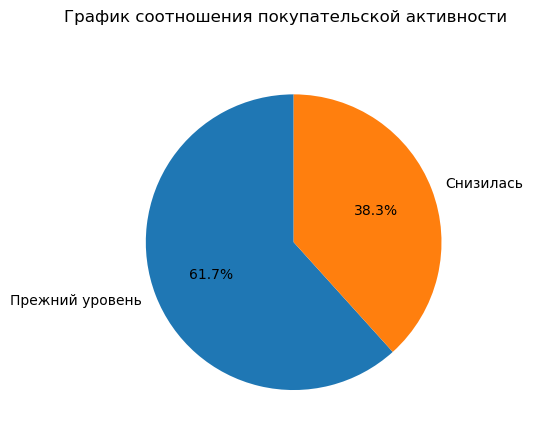

In [61]:
plt.pie(market_file.groupby('Покупательская_активность')['Покупательская_активность'].count(),labels=market_file.groupby('Покупательская_активность')['Покупательская_активность'].count().index, autopct='%1.1f%%', startangle=90)
plt.suptitle('График соотношения покупательской активности')
plt.show()

62% покупателей не снижали уровень своей активности

Изучим переменную `Тип сервиса`

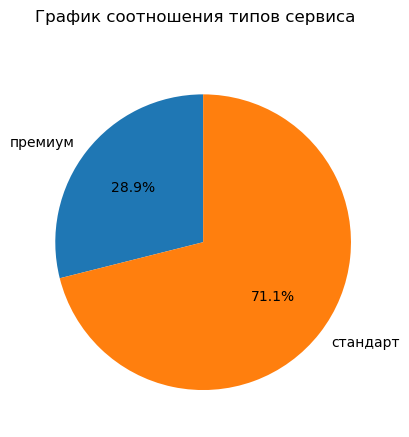

In [62]:
plt.pie(market_file.groupby('Тип_сервиса')['Тип_сервиса'].count(),labels=market_file.groupby('Тип_сервиса')['Тип_сервиса'].count().index, autopct='%1.1f%%', startangle=90)
plt.suptitle('График соотношения типов сервиса')
plt.show()

29% клиентов используют премиум сервис

Изучим переменную `Разрешить сообщать`

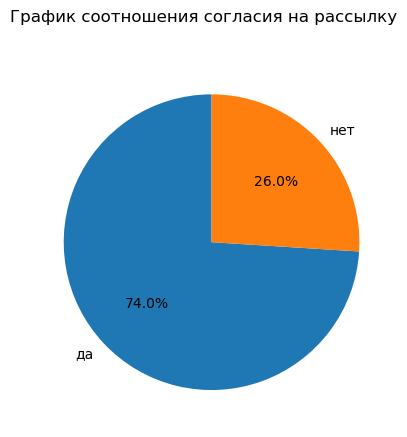

In [63]:
plt.pie(market_file.groupby('Разрешить_сообщать')['Разрешить_сообщать'].count(),labels=market_file.groupby('Разрешить_сообщать')['Разрешить_сообщать'].count().index, autopct='%1.1f%%', startangle=90)
plt.suptitle('График соотношения согласия на рассылку')
plt.show()

74% покупателей разрешили отправлять им персональные предложения и акции

Изучим переменную `Маркет_актив_6_мес`

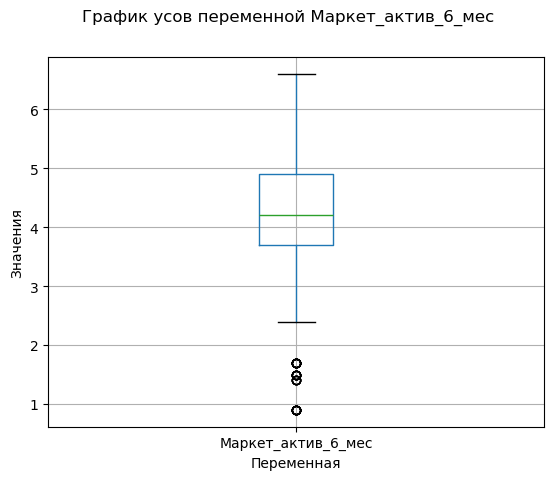

In [64]:
market_file.boxplot('Маркет_актив_6_мес')
plt.suptitle('График усов переменной Маркет_актив_6_мес')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

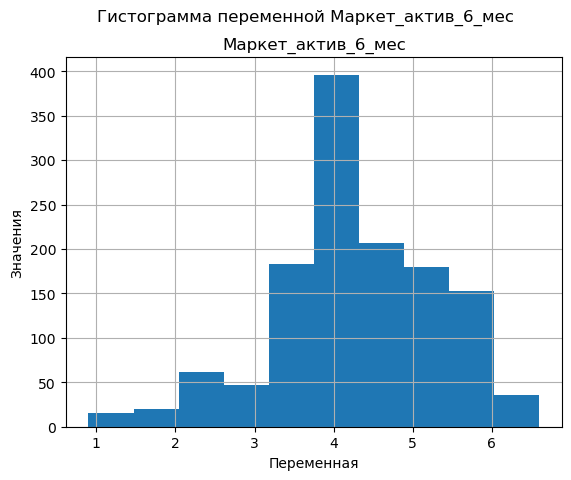

In [65]:
market_file.hist('Маркет_актив_6_мес',bins=10)
plt.suptitle('Гистограмма переменной Маркет_актив_6_мес')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

На кадого покупателя приходится от 1 до 6 количества рассылок, звонков, показов рекламы и прочего. В среднем с каждым покупателем взаимодействуют по 4 раза за полгода.

Изучим переменную `Маркет_актив_тек_мес`

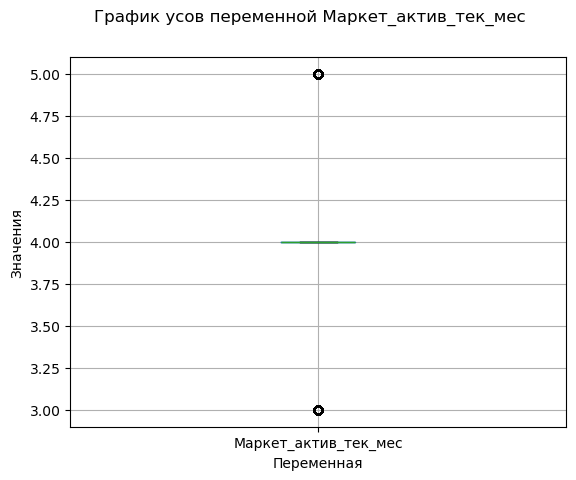

In [66]:
market_file.boxplot('Маркет_актив_тек_мес')
plt.suptitle('График усов переменной Маркет_актив_тек_мес')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

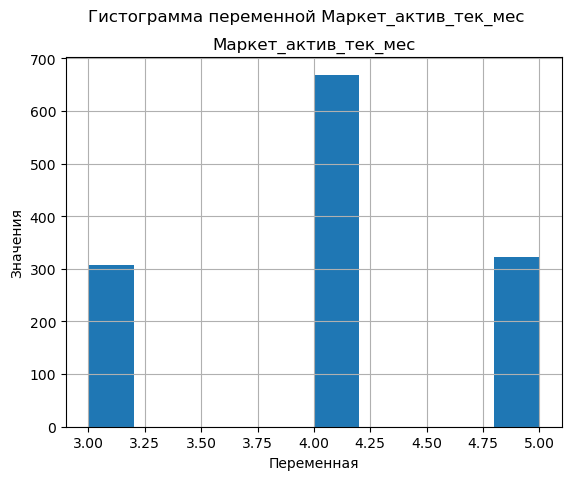

In [67]:
market_file.hist('Маркет_актив_тек_мес',bins=10)
plt.suptitle('Гистограмма переменной Маркет_актив_тек_мес')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

В текущем месяце на кадого покупателя приходится от 3 до 5 количества рассылок, звонков, показов рекламы и прочего.

Изучим переменную `Длительность`

In [68]:
market_file['Длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

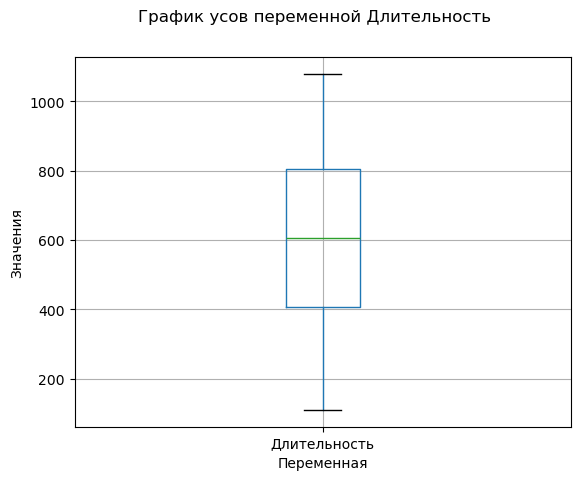

In [69]:
market_file.boxplot('Длительность')
plt.suptitle('График усов переменной Длительность')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

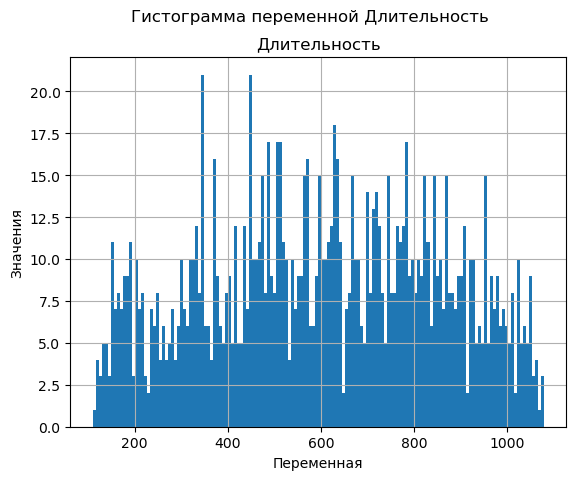

In [70]:
market_file.hist('Длительность',bins=150)
plt.suptitle('Гистограмма переменной Длительность')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

75% клиентов зарегистрировалось на сайте больше года назад.

Изучим переменную `Акционные_покупки`

In [71]:
market_file['Акционные_покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64

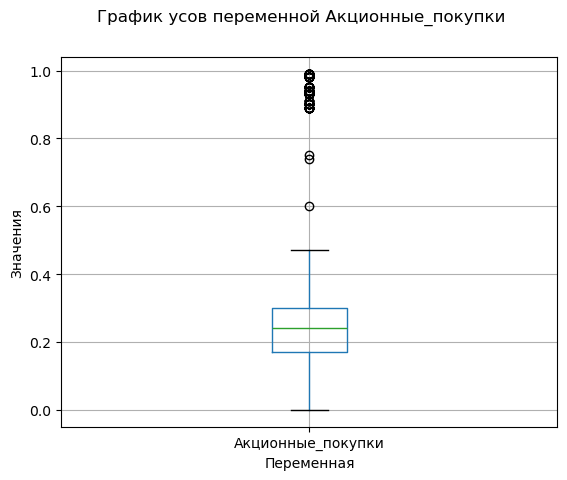

In [72]:
market_file.boxplot('Акционные_покупки')
plt.suptitle('График усов переменной Акционные_покупки')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

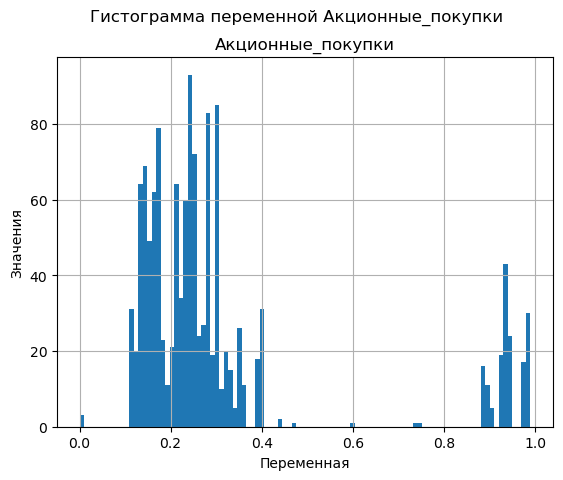

In [73]:
market_file.hist('Акционные_покупки',bins=100)
plt.suptitle('Гистограмма переменной Акционные_покупки')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

В среднем доля аукционных покупок за полгода составила 24% у покупателей.

Изучим переменную `Популярная_категория`

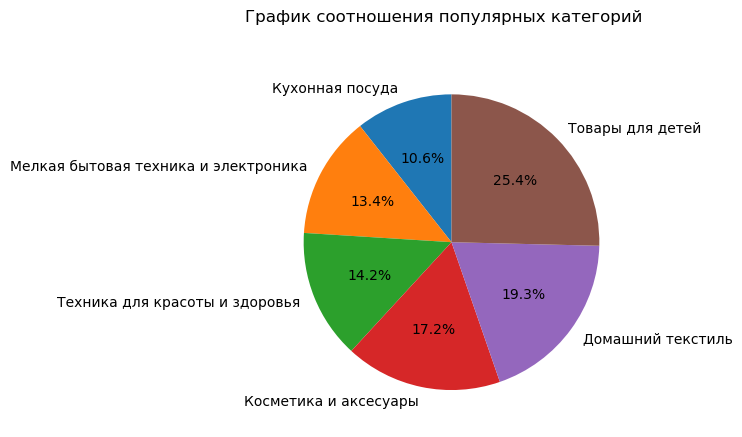

In [74]:
plt.pie(market_file.groupby('Популярная_категория')['Популярная_категория'].count().sort_values(),labels=market_file.groupby('Популярная_категория')['Популярная_категория'].count().sort_values().index, autopct='%1.1f%%', startangle=90)
plt.suptitle('График соотношения популярных категорий')
plt.show()

Самые популярные категории: Товары для детей; Домашний текстиль; Косметика и аксесуары.

Изучим переменную `Средний_просмотр_категорий_за_визит`

In [75]:
market_file['Средний_просмотр_категорий_за_визит'].describe()

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64

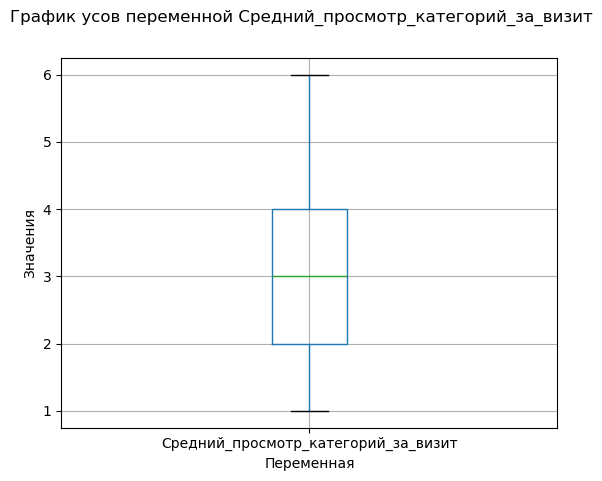

In [76]:
market_file.boxplot('Средний_просмотр_категорий_за_визит')
plt.suptitle('График усов переменной Средний_просмотр_категорий_за_визит')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

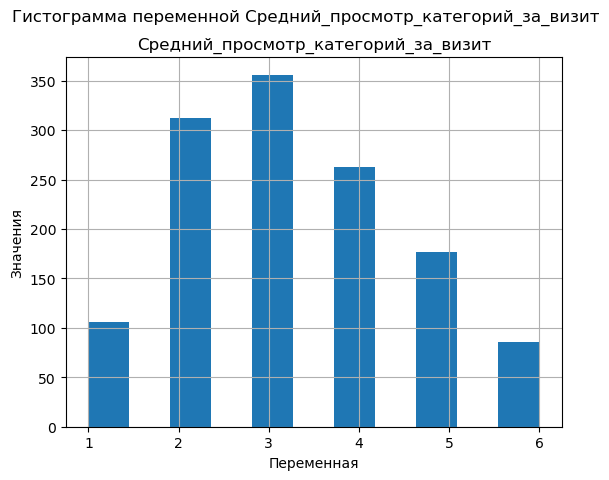

In [77]:
market_file.hist('Средний_просмотр_категорий_за_визит',bins=11)
plt.suptitle('Гистограмма переменной Средний_просмотр_категорий_за_визит')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

В среднем покупатель просмотривает 3 категории за визит

Изучим переменную `Неоплаченные_продукты_штук_квартал`

In [78]:
market_file['Неоплаченные_продукты_штук_квартал'].describe()

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

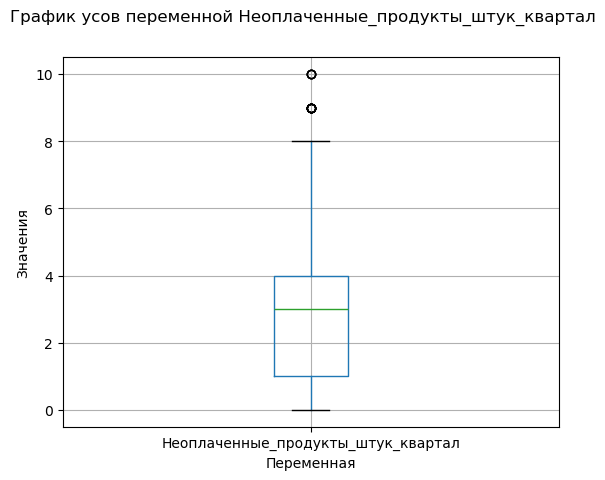

In [79]:
market_file.boxplot('Неоплаченные_продукты_штук_квартал')
plt.suptitle('График усов переменной Неоплаченные_продукты_штук_квартал')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

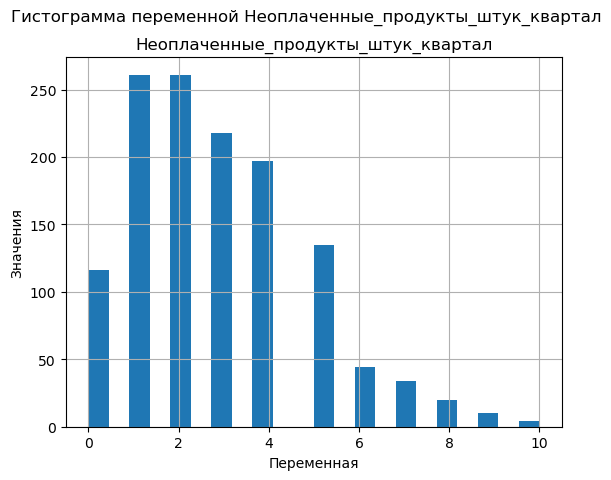

In [80]:
market_file.hist('Неоплаченные_продукты_штук_квартал',bins=22)
plt.suptitle('Гистограмма переменной Неоплаченные_продукты_штук_квартал')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

В среднем у покупателя 3 неоплаченных товара лежит в корзине за последние 3 месяца.

Изучим переменную `Ошибка_сервиса`

In [81]:
market_file['Ошибка_сервиса'].describe()

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64

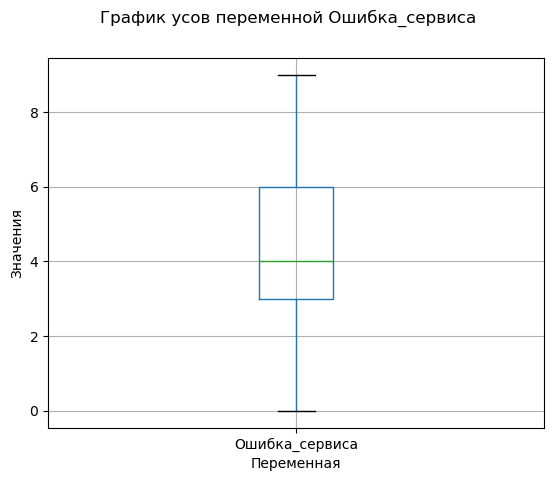

In [82]:
market_file.boxplot('Ошибка_сервиса')
plt.suptitle('График усов переменной Ошибка_сервиса')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

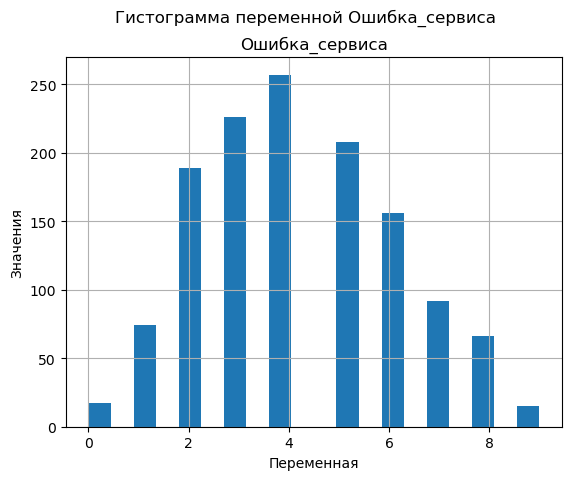

In [83]:
market_file.hist('Ошибка_сервиса',bins=20)
plt.suptitle('Гистограмма переменной Ошибка_сервиса')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

В среднем покупатель столкнулся с 4 сбоями, во время посещения сайта.

Изучим переменную `Страниц_за_визит`

In [84]:
market_file['Страниц_за_визит'].describe()

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64

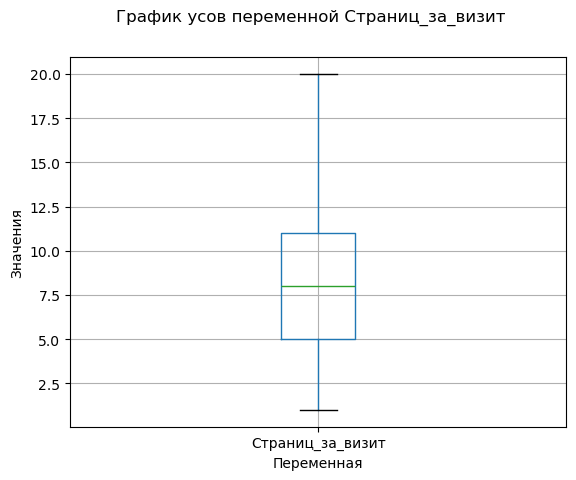

In [85]:
market_file.boxplot('Страниц_за_визит')
plt.suptitle('График усов переменной Страниц_за_визит')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

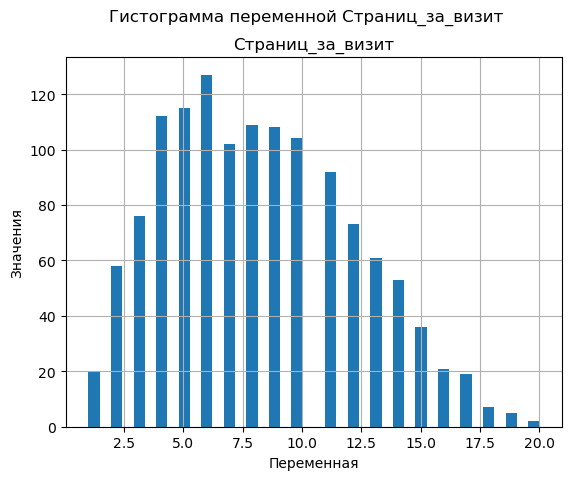

In [86]:
market_file.hist('Страниц_за_визит',bins=40)
plt.suptitle('Гистограмма переменной Страниц_за_визит')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

В среднем покупатель просматривает 8 страниц за один визит на сайте за последние 3 месяца.

### Исследуем признаки датафрейма `market_money`

In [87]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Изучим переменную `Период`

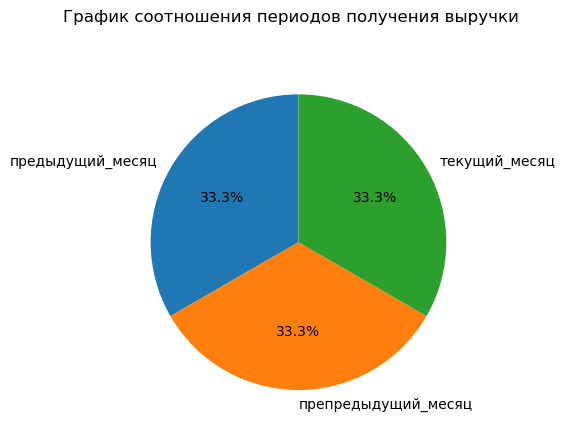

In [88]:
plt.pie(market_money.groupby('Период')['Период'].count(),labels=market_money.groupby('Период')['Период'].count().index, autopct='%1.1f%%', startangle=90)
plt.suptitle('График соотношения периодов получения выручки')
plt.show()

1/3 выручки было зафиксировано в этом месяце

Изучим переменную `Выручка`

In [89]:
market_money['Выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64

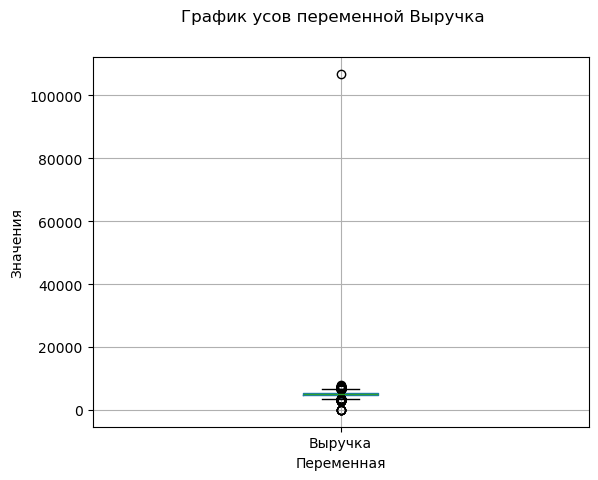

In [90]:
market_money.boxplot('Выручка')
plt.suptitle('График усов переменной Выручка')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

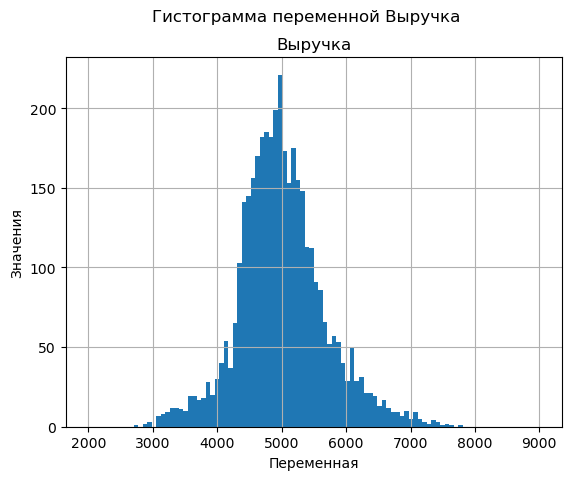

In [91]:
market_money.hist('Выручка',bins=100,range = (2000,9000))
plt.suptitle('Гистограмма переменной Выручка')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

Есть высокое значение Выручки. Посмотрим в каком оно наблюдении.

In [92]:
market_money[market_money['Выручка']>100000]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Значение превышает 75 персентиль в 2 раза. Оно похоже на аномальное. Удалим его.

In [93]:
market_money = market_money[market_money['Выручка']<100000]

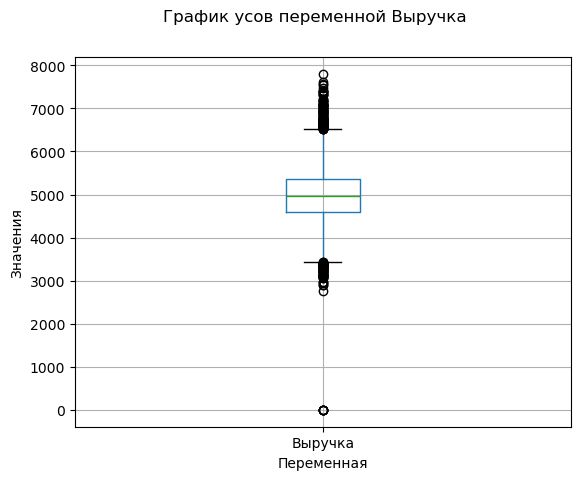

In [94]:
market_money.boxplot('Выручка')
plt.suptitle('График усов переменной Выручка')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

В среднем сумма выручки за период составляет 4959

Посмотрим выручку по месяцам

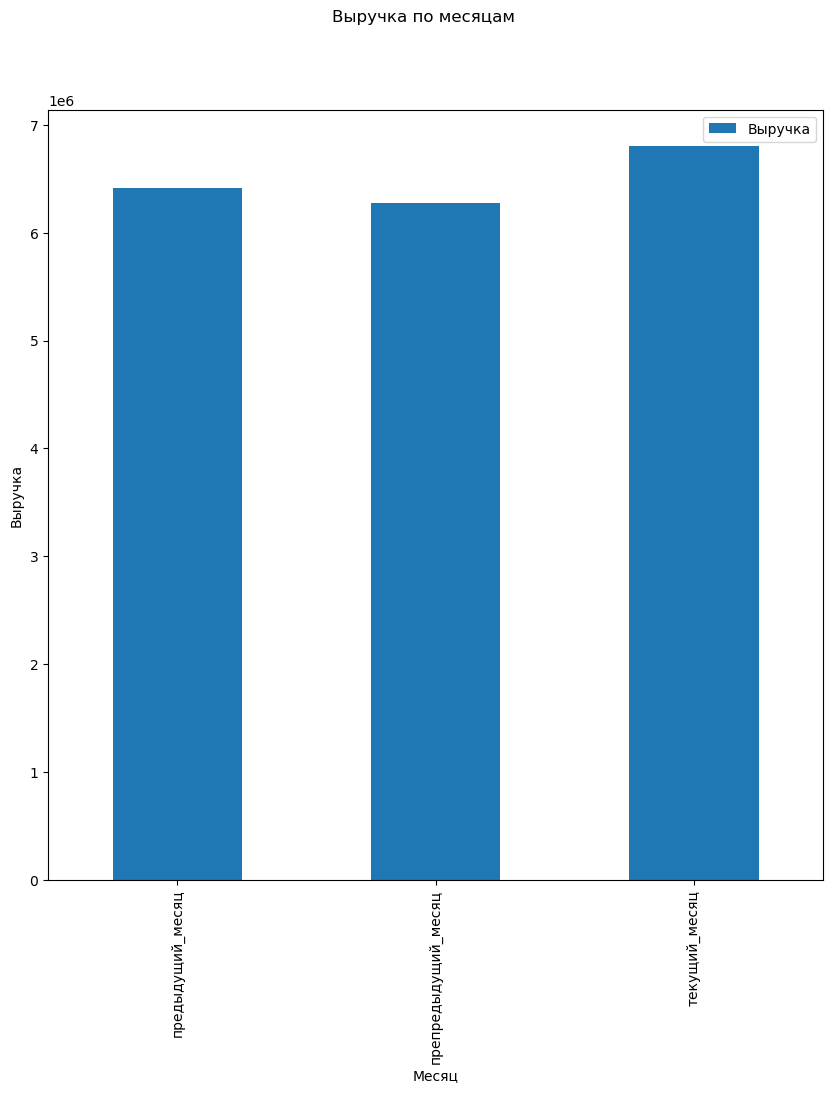

In [95]:
market_money.pivot_table(index='Период', values = 'Выручка', aggfunc='sum').plot(kind='bar', figsize=(10,10))
plt.suptitle('Выручка по месяцам')
plt.ylabel('Выручка')
plt.xlabel('Месяц')
plt.show()

Распределение выручки за последние 3 месяца похоже на равномерное. 

Посмотрим каждый месяц по отдельности

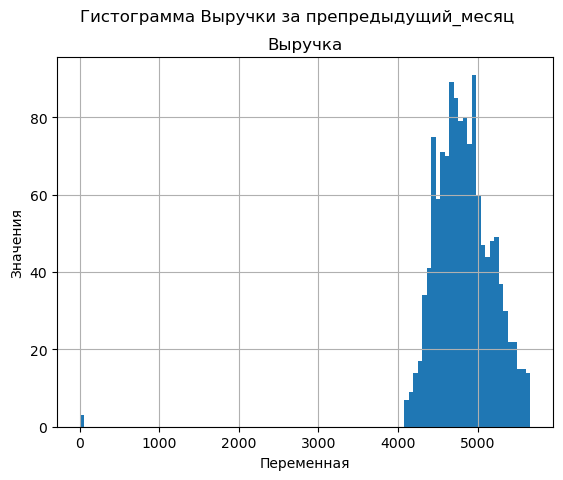

In [96]:
market_money[market_money['Период']=='препредыдущий_месяц'].hist('Выручка',bins=100,)
plt.suptitle('Гистограмма Выручки за препредыдущий_месяц')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

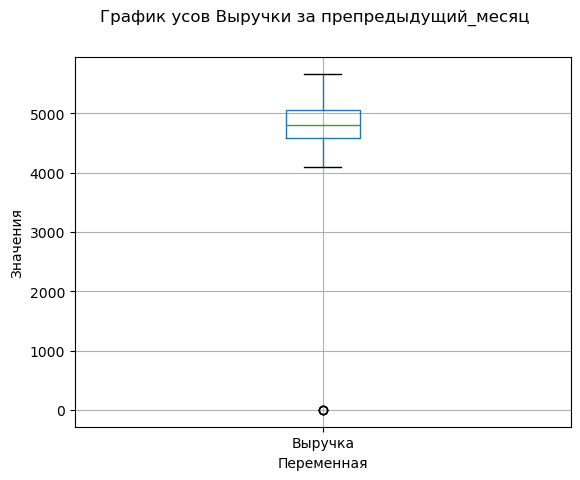

In [97]:
market_money[market_money['Период']=='препредыдущий_месяц'].boxplot('Выручка')
plt.suptitle('График усов Выручки за препредыдущий_месяц')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

2 месяца назад многие пользователи не пользовались магазином. Аномальных значений в данных нет.

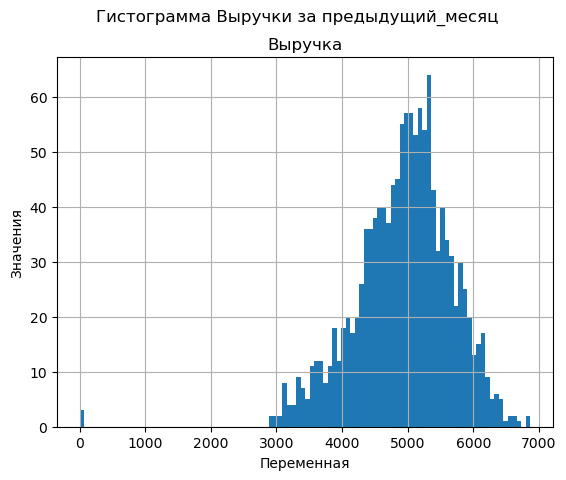

In [98]:
market_money[market_money['Период']=='предыдущий_месяц'].hist('Выручка',bins=100,)
plt.suptitle('Гистограмма Выручки за предыдущий_месяц')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

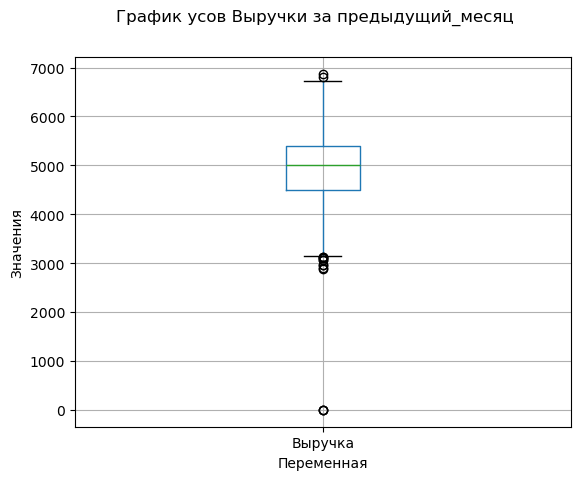

In [99]:
market_money[market_money['Период']=='предыдущий_месяц'].boxplot('Выручка')
plt.suptitle('График усов Выручки за предыдущий_месяц')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

Месяца назад также были пользователи, которые не пользовались магазином. Аномальных значений в данных нет.

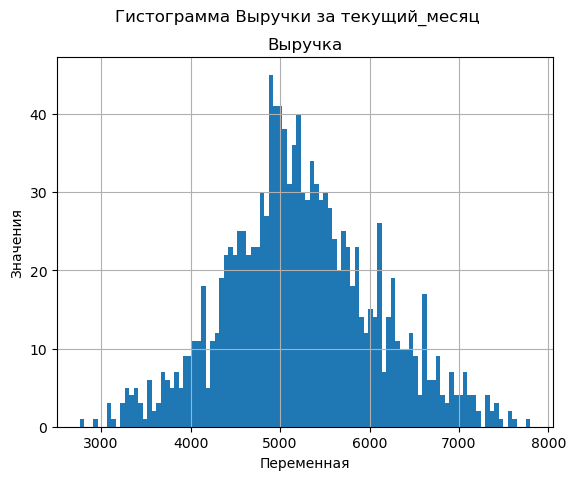

In [100]:
market_money[market_money['Период']=='текущий_месяц'].hist('Выручка',bins=100,)
plt.suptitle('Гистограмма Выручки за текущий_месяц')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

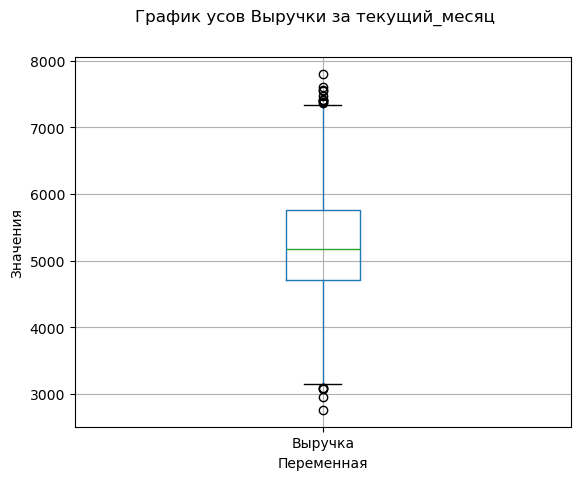

In [101]:
market_money[market_money['Период']=='текущий_месяц'].boxplot('Выручка')
plt.suptitle('График усов Выручки за текущий_месяц')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

В этом месяце нет аномальных значений. Скорее всего по окончанию месяца, если пользователей не совершал покупок, то ему присваивается значение 0. Поэтому в текущем месяце пока 0 нет. 

### Исследуем признаки датафрейма `market_time`

In [102]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Изучим переменную `Период`

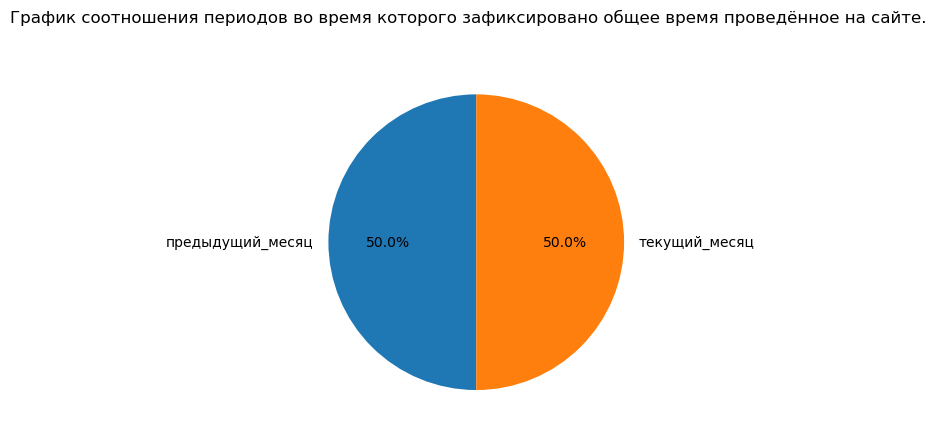

In [103]:
plt.pie(market_time.groupby('Период')['Период'].count(),labels=market_time.groupby('Период')['Период'].count().index, autopct='%1.1f%%', startangle=90)
plt.suptitle('График соотношения периодов во время которого зафиксировано общее время проведённое на сайте.')
plt.show()

Периодов во время которого зафиксировано общее время проведённое на сайте одинаковое количество.

Изучим переменную `минут`

In [104]:
market_time['минут'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

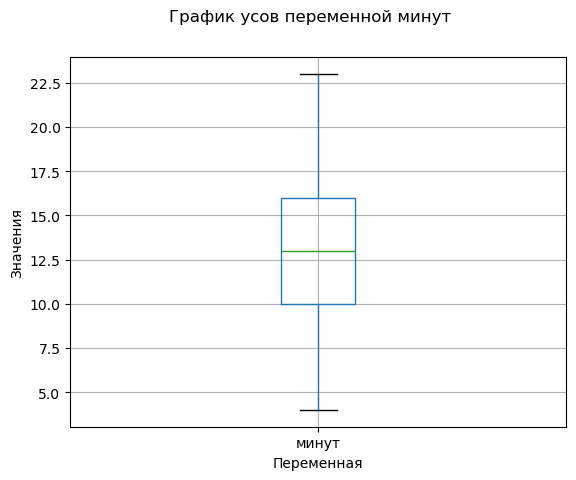

In [105]:
market_time.boxplot('минут')
plt.suptitle('График усов переменной минут')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

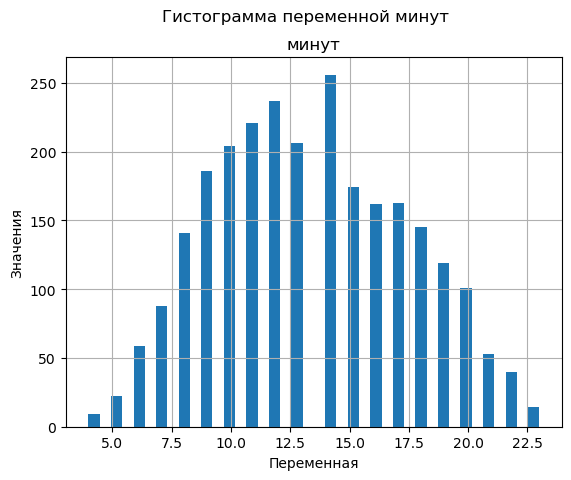

In [106]:
market_time.hist('минут',bins=40)
plt.suptitle('Гистограмма переменной минут')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

В среднем покупатели проводят на сайте 13 минут.

### Исследуем признаки датафрейма `money`

In [107]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Изучим переменную `Прибыль`

In [108]:
money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

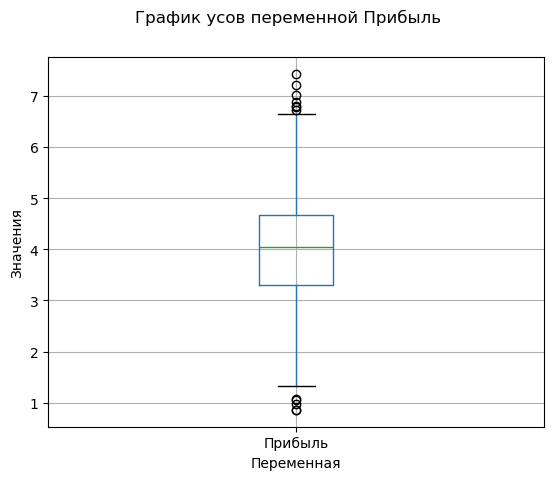

In [109]:
money.boxplot('Прибыль')
plt.suptitle('График усов переменной Прибыль')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

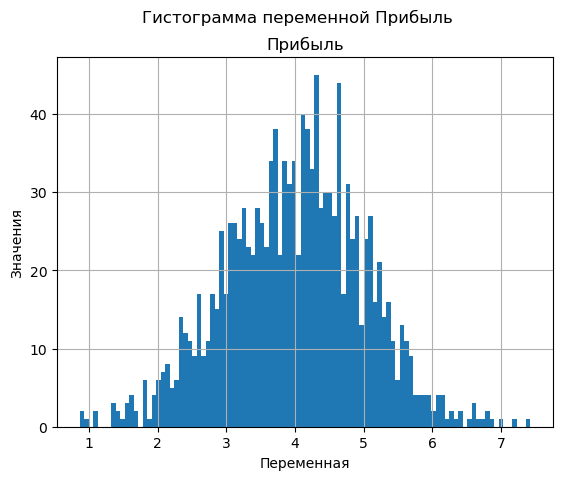

In [110]:
money.hist('Прибыль',bins=100)
plt.suptitle('Гистограмма переменной Прибыль')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

Среднемесячная прибыль продавца за последние 3 месяца составляет 4.

### Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

Вывыдем перечень клиентов, котоорые совершали покупки в последние месяца

In [111]:
good_clients = (market_money.groupby('id').prod().query('Выручка > 0')).index

TypeError: agg function failed [how->prod,dtype->object]

In [ ]:
good_clients

Оставим только активных клиентов

In [ ]:
market_file = market_file[market_file['id'].isin(good_clients)]

In [ ]:
market_file.shape

В данных было предоставлено 1300 пользователей 1297 из которых являются активными. У 38% пользователей снизилась активность, только 29% из них использует премиум тариф. Большинство пользователей согласны получать маркетинговую рассылку. В среднем с каждым пользователем взаимодействуют по 4 раза в полгода. 75% клиентов зарегистрированы на сайте больше года. Самые популярные категории у клиентов: Товары для детей; Домашний текстиль; Косметика и аксесуары. 24% от всех покупок составляют аукционные товары. В среднем выручка в месяц от каждого клиента составляет 4959. Клиенты обычно проводят на сайте около 13 минут и просмотривают окола 8 категорий.

## Объединение таблиц

В `market_money`, `market_time` добавим столбцы по периодам, чтобы после добавить информацию в общую таблицу.

In [ ]:
market_money.info()

In [ ]:
market_money.shape

In [ ]:
market_money_group = market_money.pivot_table(index = 'id', columns=['Период'] , values = 'Выручка', aggfunc='sum')

In [ ]:
market_money_group.head()

In [ ]:
market_money_group.shape

In [ ]:
market_time.info()

In [ ]:
market_time.shape

In [ ]:
market_time_group = market_time.pivot_table(index = 'id', columns=['Период'] , values = 'минут', aggfunc='sum')

In [ ]:
market_time_group.head()

In [ ]:
market_time_group.shape

Объединим датафреймы `market_file`, `market_money`, `market_time`. 

In [ ]:
market_file.shape

In [ ]:
data = market_file.merge(market_money_group, on='id', how='left')

In [ ]:
data.shape

In [ ]:
data = data.merge(market_time_group, on='id', how='left')

In [ ]:
data.shape

In [ ]:
data.head()

Переименуем столбцы с периодом

In [ ]:
data.columns = data.columns.str.replace('x','cash')

In [ ]:
data.columns = data.columns.str.replace('y','time')

In [ ]:
data.head()

In [ ]:
data.isna().sum()

В данных естьм пропуск, это значение аномально высокой выручки удалённое выше. Удалим эту строку

In [ ]:
data = data.dropna(subset=['текущий_месяц_cash'])

In [ ]:
data.isna().sum()

## Корреляционный анализ

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.drop('id', axis=1).corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Тепловая карта стандартного коэффициента корреляции Спирмана')
plt.show()

Есть сильная связь между выручкой за предыдущий месяц и выручкой за этот месяц.

Также посмотрим зависимости между категориальными и количественными признаками

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.drop('id', axis=1).phik_matrix(), annot=True, cmap='cividis')
plt.title('Тепловая карта коэффициента корреляции между категориальными и порядковыми переменными')
plt.show()

Покупательская активность зависит от: количество просмотренных страниц за визит, количества проведенных минут на сайте в предыдущем месяце и в текущем, количества полученных маркетинговых уведемлений и среднее количесвто просмотренных категорий за визить.

В данных нет линейных связей, зато есть категориальные зависимости целевого признака от признаков: количество просмотренных страниц за визит, количества проведенных минут на сайте в предыдущем месяце и в текущем, количества полученных маркетинговых уведемлений и среднее количесвто просмотренных категорий за визить.

## Использование пайплайнов

Обозначим, какие данные требуют масштабирования, а какие — кодирования. 

In [ ]:
data.head()

In [ ]:
ohe_columns = [ 
    'Разрешить_сообщать',
    'Популярная_категория',
    
    
]
ord_columns = [
     'Тип_сервиса'
    
]
num_columns = ['Маркет_актив_6_мес', 
               'Маркет_актив_тек_мес', 
               'Длительность', 
               'Акционные_покупки', 
               'Средний_просмотр_категорий_за_визит',
              'Неоплаченные_продукты_штук_квартал',
               'Ошибка_сервиса',
               'Страниц_за_визит',
               'предыдущий_месяц_cash','препредыдущий_месяц', 'текущий_месяц_cash', 'предыдущий_месяц_time' ,'текущий_месяц_time', 
              ] 

Добавляем OHE-кодирование в пайплайн

In [ ]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
    )

Добавляем Ordinal-кодирование в пайплайн

In [ ]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
            
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Объединяем шаги подготовки

In [ ]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Создаём итоговый пайплайн для обучения модели

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [ ]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

Разделим данные на тренировочные и тестовые

In [ ]:
data = data.set_index('id')
data.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Покупательская_активность'], axis=1),
    data['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['Покупательская_активность'])

In [ ]:
X_train.shape, X_test.shape

Создаем словарь для перебора значений

In [ ]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(4,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3,19),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            penalty='elasticnet', solver='saga'
        )],
        'models__l1_ratio': range(0, 1),
        'models__C': range(1,8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE, probability= True, kernel='linear'
            
        )],
        'models__degree': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

<span style="color: blue; font-weight: bold">Комментарий ревьюера 2: </span> ✔️\
<span style="color: green"> 👍</span>

Спомощью сетки найдем лучшую модель и методы 

Нам важно оценить качество модели с учётом всех возможных порогов, поэтому для критерия оптимизации возьмем метрику ROC-AUC.

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=4,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

In [ ]:
randomized_search.fit(X_train, y_train)

In [ ]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

In [ ]:
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Рассчитаем прогноз на тестовых данных

In [ ]:
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]

In [ ]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучше всего показала себя модель LogisticRegression, где C=5, l1_ratio=0, penalty='elasticnet',
                                    random_state=42, solver='saga' и масштабирование происходит с помощью MinMaxScaler(). Метрика на тестовых данных равна 0.91

## Анализ важности признаков

In [ ]:
best_model = randomized_search.best_estimator_.named_steps['models']

In [ ]:
preprocessor = randomized_search.best_estimator_['preprocessor']

In [ ]:
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
features_names = preprocessor.get_feature_names_out().tolist()

In [ ]:
X_test_feature = pd.DataFrame(X_test_preprocessed, columns=features_names)

Строим график важности признаков

In [ ]:
coefficients = best_model.coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': X_test_feature.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) 
plt.title('График важности признаков')
plt.show()

Самыми важными оказались признаки: количество страниц просматриваемых на сайте, время проведенное на сайте в этом и прошлом месяце, процент акционных покупок, количество просмотренных категорий за визит, количество неоплаченных товаров в корзине, выручка от клиента за предпредыдущий и предыдущий месяца.

Визуализируем вклад признаков в каждое предсказание модели

In [ ]:
explainer = shap.LinearExplainer(best_model,X_test_feature)
shap_values = explainer(X_test_feature)

In [ ]:
plt.rcParams['figure.figsize'] = [40,45]  
plt.rcParams['figure.dpi'] = 100  


shap.summary_plot(shap_values.values, 
                 features=shap_values.data,
                 feature_names=shap_values.feature_names,
                 plot_type='dot',  # Аналог beeswarm
                 show=False)


ax = plt.gca()
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='x', labelsize=7)
plt.tight_layout()

plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

На основе метода SHAP можно следать следующие выводы: 
- самые важные признаки: количество просмотренных страниц, время проведенное на сайте в этом и (пред)/предыдущем месяце, количество акционных покупок, количество просмотренных категорий
- малую значимость имеют признаки: разрешение уведомлений, выручка в этом месяце, ошибки сервиса, маркетинговая активность.

Таким образом на основе двух методов:
- признаки мало значимые для модели: разрешение уведомлений, выручка в этом месяце, ошибки сервиса, маркетинговая активность.
- признаки сильнее всего влияющие на целевой признак: количество просмотренных страниц, время проведенное на сайте в этом и (пред)/предыдущем месяце, количество акционных покупок, количество просмотренных категорий



Эти наблюдения при моделировании и принятии бизнес-решений можно использовать следующим образом:
- Для моделирования: можно попробовать убрать признаки, которые влияют меньше всего на модель и посмотреть, как изменится качество предсказания
- Для бизнес-решений: знание весов признаков может помочь при распределении бюджета. Например, можно сделать уклон в сторону повешения времени нахождения клиента на сайте.

## Сегментация покупателей

Далее исследование будет проводится для группы клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. 

Сначала выполним сегментацию покупателей, используя результаты моделирования и данные о прибыльности покупателей.

Условия поподания клиента в целевой сегмент:
- прибыль > 3
- вероятность снижения покупательской способности больше 70% 

Добавим новый столбец: вероятность снижения покупательской активности клиента в следующие три месяца

In [ ]:
data['вер_снижения_пок_способ'] = randomized_search.predict_proba(data)[:, 1]
data.head()

In [ ]:
data.shape

Также добавим значение прибыли по каждому покупателю

In [ ]:
data = data.merge(money.set_index('id'), on='id', how='left')

In [ ]:
data.shape

Выделим целевой сегмент

In [ ]:
seg_main = data.query('вер_снижения_пок_способ>0.7 and Прибыль>3')

Построим график распределения сегментов

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(data= seg_main, x = 'вер_снижения_пок_способ', y = 'Прибыль', label='исследуемый сегмент', color='blue')
sns.scatterplot(data= data.query('not ( вер_снижения_пок_способ>0.7 and Прибыль>3)'), x = 'вер_снижения_пок_способ', y = 'Прибыль', label='другие сегменты', color='purple')
plt.legend()
plt.title('График распределения сегментов')
plt.axvline(x=0.7, color='green', linestyle='--')
plt.axhline(y=3, color='green', linestyle='--')
plt.show()

Выделим группу пользователей, которые покупают акционные товары. Критерий для отбора:
- клиент покупает акционные продукты чаще, чем 75% покупателей

In [ ]:
seg_main['Акционные_покупки'].describe()

In [ ]:
perc = np.percentile(data['Акционные_покупки'], 75)

In [ ]:
group_client = seg_main[seg_main['Акционные_покупки'] > np.percentile(data['Акционные_покупки'], 75)]

In [ ]:
group_client.head()

In [ ]:
group_client.shape

Узучим самые популярные категории у нашей целевой группы

In [ ]:
plt.pie(group_client.groupby('Популярная_категория')['Популярная_категория'].count().sort_values(),labels=group_client.groupby('Популярная_категория')['Популярная_категория'].count().sort_values().index, autopct='%1.1f%%', startangle=90)

plt.suptitle('График соотношения популярных категорий у целевой группы покупателей')
plt.show()

Узучим самые популярные категории у покупателей акционных товаров, которые не подвержены снижению активности

In [ ]:
plt.pie(data.query('not( вер_снижения_пок_способ>0.7 ) and Прибыль>3 and Акционные_покупки > @perc').groupby('Популярная_категория')['Популярная_категория'].count().sort_values(),labels=group_client.groupby('Популярная_категория')['Популярная_категория'].count().sort_values().index, autopct='%1.1f%%', startangle=90)
plt.suptitle('График соотношения популярных категорий у покупателей акционных товаров, которые не подвержены снижению активности')
plt.show()

Больше всего группой было куплено товаров для детей, косметики и аксусуаров.

Можно сделать акценты на этих категориях. Например акции набора наклеек за покупки для дальнейшей скидки на любимые категории. 

Посмотрим, какое количество пользователей подписано на рассылки

In [ ]:
plt.pie(group_client.groupby('Разрешить_сообщать')['Разрешить_сообщать'].count(),labels=group_client.groupby('Разрешить_сообщать')['Разрешить_сообщать'].count().index, autopct='%1.1f%%', startangle=90)
plt.suptitle('График соотношения разрешений на рассылку у целевой группы покупателей')
plt.show()

In [ ]:
plt.pie(data.query('not( вер_снижения_пок_способ>0.7 ) and Прибыль>3 and Акционные_покупки > @perc').groupby('Разрешить_сообщать')['Разрешить_сообщать'].count(),labels=group_client.groupby('Разрешить_сообщать')['Разрешить_сообщать'].count().index, autopct='%1.1f%%', startangle=90)
plt.suptitle('График соотношения разрешений на рассылку у покупателей акционных товаров, которые не подвержены снижению активности')
plt.show()

77% целевой группы подписано на рассылку. Можно отправлять им индивидуальные предложения.

Посмотрим какое распределение у неоплаченных товарах в корзине

In [ ]:
group_client['Неоплаченные_продукты_штук_квартал'].describe()

In [ ]:
group_client.hist('Неоплаченные_продукты_штук_квартал',bins=22)
plt.suptitle('Гистограмма переменной Неоплаченные_продукты_штук_квартал у целевой группы')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

In [ ]:
data.query('not( вер_снижения_пок_способ>0.7 ) and Прибыль>3 and Акционные_покупки > @perc')['Неоплаченные_продукты_штук_квартал'].describe()

In [ ]:
data.query('not( вер_снижения_пок_способ>0.7 ) and Прибыль>3 and Акционные_покупки > @perc').hist('Неоплаченные_продукты_штук_квартал',bins=22)
plt.suptitle('Гистограмма переменной Неоплаченные_продукты_штук_квартал у покупателей акционных товаров, которые не подвержены снижению активности')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

У большинства по 4 продукта лежат неоплаченными в корзине, можно сделать по ним также акцию.

Посмотрим какое распределение у вермени нахождения на сайте

In [ ]:
group_client.hist('предыдущий_месяц_time',bins=22)
plt.suptitle('Гистограмма времени нахождения на сайте у целевой группы')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

In [ ]:
data.query('not( вер_снижения_пок_способ>0.7 ) and Прибыль>3 and Акционные_покупки > @perc').hist('предыдущий_месяц_time',bins=22)
plt.suptitle('Гистограмма времени нахождения на сайте у покупателей акционных товаров, которые не подвержены снижению активности')
plt.ylabel('Значения')
plt.xlabel('Переменная')
plt.show()

Покупатели с отсутствием сколнности к снижению активности проводят на сайте намного больше времени, чем покупатели расположенные к ней.

Стоит рассмотреть варианты повышения времяпровождения на сайте. Можно воспользоваться помощью маркетологов, для разработки инструментов повышения внимания и вовлеченности покупателей на сайте.

Для исследования был взят сегмент пользователей, которые покупают много акционных товаров и которые подвержены снижению активности в следующие 3 месяца. 

Большинство подписаны на рассылку и покупают товары для детей, косметику и аксесуары. Этим пользователям можно предложить следующие акции:
- сделать скидку на неоплаченные товары в корзине (до 4х позиций)
- отправить индивидуальные предложения по скидкам и акциям на самые популярные категории товаров
- акция набора наклеек/фишек за покупки для дальнейшей скидки на любимые категории/товары.


Также стоит рассмотреть варианты повышения времяпровождения на сайте. Можно воспользоваться помощью маркетологов, для разработки инструментов повышения внимания и вовлеченности покупателей на сайте.

## Общий вывод


**Задача:**
    разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
    
Подзадачи:
- Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.
    


**Исходные данные**: данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении; данные о выручке, которую получает магазин с покупателя; данные о времени (в минутах), которое покупатель провёл на сайте в течение периода; данные о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

Была проведена предобработка данных: переименованы столбцы; скорректированы типы данных; проверено наличие пропусков; скорректированы опечатки в значениях признаков; удалены дубликаты.

Для поиска лучшей модели была использована сетка. В подборе участвовали: 4 модели, и у каждой из них подбирался отдельно минимум один гиперпараметр для подбора оптимальной. В качестве критерия для поиска оптимума использовалась метрика roc-auc, так как она учитывает качество модели с учетом всех возможных порогов.

Лучшей модель для данной задачи является  LogisticRegression: с гиперпаратроми где C=5, l1_ratio=0, penalty='elasticnet', random_state=42, solver='saga' и масштабирование происходит с помощью MinMaxScaler(). Она дает качество 91% на тестовых данных.

Для исследования была выбрана группа покупателей с высоким процентовм покупок акционных товаров и с вероятностью снижения покупательской способности. Всего таких покупателей от общего количества пользователей в тестовых данных 25%.
Большинство из них подписано на рассылки и их любимые категории это детсткие товары, косметика и аксесуары. 

Если модель предсказывает вероятность ухода больше 70% у этих покупателей, то им можно предложить следующие акции:
-сделать скидку на неоплаченные товары в корзине (до 4х позиций)
-отправить индивидуальные предложения по скидкам и акциям на самые популярные категории товаров
-акция набора наклеек/фишек за покупки для дальнейшей скидки на любимые категории/товары.